In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import poppy

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [2]:
osys = poppy.OpticalSystem()
osys.add_pupil(poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.025, fov_arcsec=0.75)  # image plane coordinates in arcseconds



In [3]:
osys.planes[1].pixelscale

0.025

In [4]:
osys.input_wavefront().amplitude

DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [5]:
osys.intermediate_wfs

In [6]:
psf,intermediate = osys.propagate_mono(2e-6)

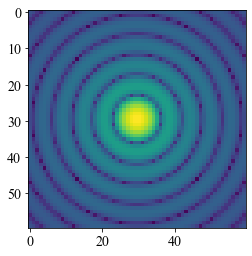

In [7]:
plt.imshow(psf.amplitude**0.25)

In [8]:
def objective(wavelength):
    psf,intermediate = osys.propagate_mono(wavelength*1e-6)   
    return (np.sum(psf.amplitude**2.))

objective(2.)

DeviceArray(0.96685994, dtype=float32)

In [9]:
thisgrad = grad(objective)
thisgrad(2.0)

DeviceArray(-0.01927825, dtype=float32)

In [10]:
%%time
print(thisgrad(2.0))

-0.019278252
CPU times: user 790 ms, sys: 191 ms, total: 981 ms
Wall time: 764 ms


## Now can we calculate a UV plane?

In [11]:
from poppy.matrixDFT import minimal_dft

In [12]:
arcsec2rad = np.pi/180./3600.
# experimental mathematics for the UV coords
arcsec2rad*psf.pixelscale * psf.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam 

DeviceArray(21.816616, dtype=float32)

In [13]:
def calc_uv(wavefront,osys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam
    pupil = wavefront.amplitude**2.
    return minimal_dft(pupil, nlamd, npix)

In [14]:
uv = calc_uv(psf,osys)

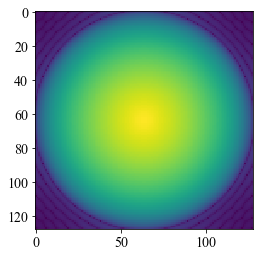

In [15]:
plt.imshow(np.abs(uv)**0.25)

## Let's try propagating some aberrations

In [16]:
wfe = poppy.ZernikeWFE(radius=1.0, coefficients=[0, 3e-8, 2e-7])


In [17]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.025 # arcsec / pix
FOV = 1 # arcsec
NWAVES = 1.0


In [18]:
coefficients_sequence = [0, 0, 0, 0, 125e-9]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.add_pupil(thinlens)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(2e-6)

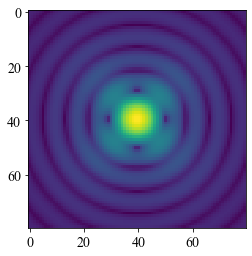

In [19]:
plt.imshow(psf.amplitude**0.5)

In [20]:
osys.planes[0].pupil_diam # m

4.0

In [21]:
psf.pixelscale # arcsec/pixel

DeviceArray(0.0125, dtype=float32)

## Non Zernike basis?

In [22]:
osys.planes[0].transmission

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
class mywavefront(poppy.AnalyticOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes poppy  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [24]:
wfe = mywavefront(2.e-6,osys.planes[0],np.zeros_like(osys.planes[0].transmission))

In [25]:
pupil = osys.planes[0]


In [26]:
osys.planes[0].sample

<bound method AnalyticOpticalElement.sample of <poppy.optics.CircularAperture object at 0x1034ed8d0>>

In [27]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.02 # arcsec / pix
FOV = 4 # arcsec
NWAVES = 1.0
NPIX = 64

osys = poppy.OpticalSystem(npix=NPIX)
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)

wf = osys.input_wavefront()
wfe = mywavefront(2.e-6,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(2e-6)

In [28]:
wf.amplitude.shape

(64, 64)

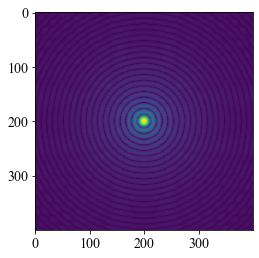

In [29]:
plt.imshow(psf.amplitude**0.5)

## Now let's try to autodiff this

In [30]:
def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = poppy.OpticalSystem(npix=NPIX)
    circular_aperture = poppy.CircularAperture(radius=RADIUS,gray_pixel=False)
    osys.add_pupil(circular_aperture)

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return calc_uv(psf,osys,npix=NPIX+1)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

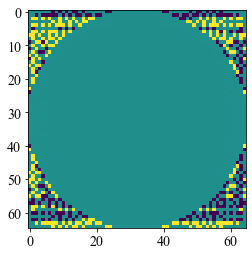

In [31]:
plt.imshow(output)

In [32]:
from jax import jacfwd, jacrev
from time import time as clock

In [33]:
phasegrad = jacrev(uv_phase)

In [34]:
%%time 
thisgrad = phasegrad(zero_phase)


CPU times: user 2.78 s, sys: 1.62 s, total: 4.4 s
Wall time: 2.2 s


In [35]:
tic = clock()
print(thisgrad.sum())
toc = clock()
print(toc-tic)

-6720.0
232.78376603126526


In [36]:
thisgrad.shape[3]

64

In [37]:
print(toc-tic)

232.78376603126526


In [38]:
otf = end_to_end(zero_phase)

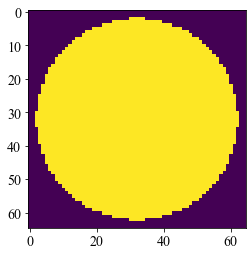

In [39]:
support = np.abs(otf) > 7.5e-5
plt.imshow(support)

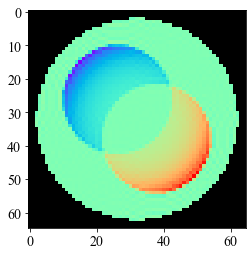

In [40]:
indices = 20

phases = onp.copy(thisgrad[:,:,indices,indices])
phases[support<1.] = np.nan
plt.imshow(phases,cmap=phasemap)


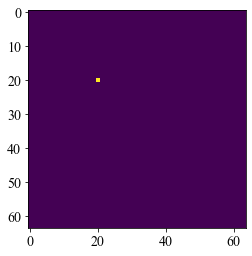

In [41]:
indices = 20
pupil_trans = osys.planes[0].transmission
phasescreen_test = onp.zeros_like(pupil_trans)
phasescreen_test[indices,indices] = 0.1

plt.imshow(phasescreen_test)

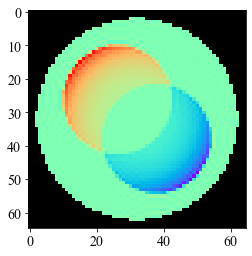

In [42]:
output = onp.array(uv_phase(phasescreen_test))
output[support<1.] = np.nan
plt.imshow(output,cmap=phasemap)


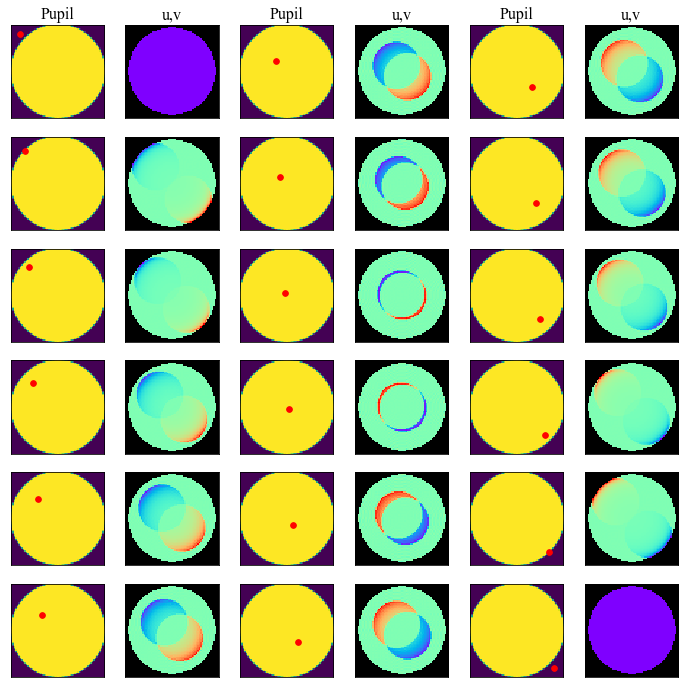

In [81]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 10
fs = 16

index_step = onp.floor((thisgrad.shape[3])/((3.*rows))).astype('int')

indices = index_step+3

for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[:,:,indices,indices])
        pupil_trans = osys.planes[0].transmission
        phases[support<1.] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += index_step

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/anoroc/paper/jacobian.pdf',bbox_inches='tight')

In [44]:
transfer_martinache = thisgrad[:,:,support>0][pupil_trans==1,:]

In [45]:
transfer_martinache.shape

(3080, 2845)

In [46]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache,full_matrices=False)

CPU times: user 75.4 ms, sys: 9.98 ms, total: 85.4 ms
Wall time: 83 ms


In [47]:
s1[6000]/s1[0]

DeviceArray(2.1069129e-09, dtype=float32)

In [48]:
np.sum((s1/s1[0])>5e-8)

DeviceArray(866, dtype=int32)

<module 'matplotlib.pyplot' from '/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

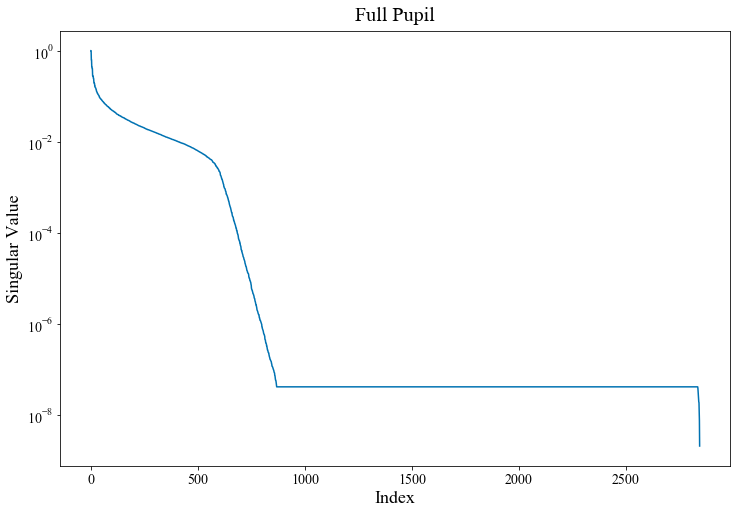

In [49]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0])
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
# plt.savefig('/Users/benjaminpope/code/anoroc/paper/kerphi_singular.pdf',bbox_inches='tight')

### What do these kernel phase maps look like?

In [50]:
v1.shape

(2845, 2845)

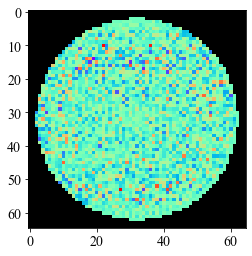

In [51]:
index = 1500

mode = 1.*onp.array(support)
mode[support>0] = v1[index,:]
mode[support<=0] = np.nan

plt.imshow(mode,cmap=phasemap)

In [52]:
u1.shape

(3080, 2845)

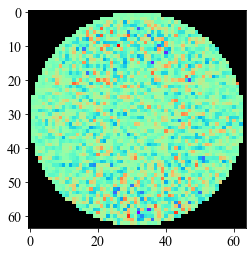

In [53]:
index = 1501

pupil_mode = 1.*onp.array(pupil_trans)
pupil_mode[pupil_trans==1.] = onp.array(u1[:,index])
pupil_mode[pupil_trans!=1.] = np.nan

plt.imshow(pupil_mode,cmap=phasemap)

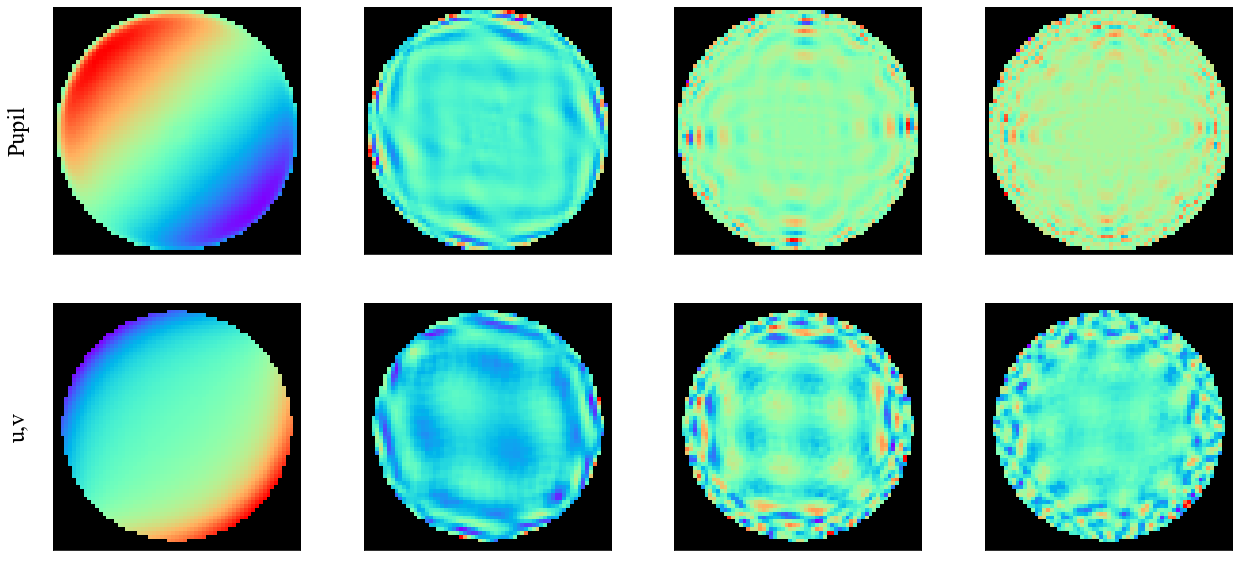

In [77]:
nsets = 4

fig, axes = plt.subplots(2,nsets,figsize=(8/3.*(nsets*2),10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_ylabel('Pupil',fontsize=24,labelpad=24)

axes[1,0].set_ylabel('u,v',fontsize=24,labelpad=24)

for j in range(nsets):
    mode = 1.*onp.array(support)
    mode[support>0] = v1[j*50,:]
    mode[support<=0] = np.nan

    axes[1,j].imshow(mode,cmap=phasemap)  
    
    wavefront = onp.ones_like(pupil_trans)
    wavefront[pupil_trans==1.] *= u1[:,j*50]
    wavefront[pupil_trans!=1.] = np.nan
    axes[0,j].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/anoroc/paper/nonsingular_modes_mono.pdf',bbox_inches='tight')

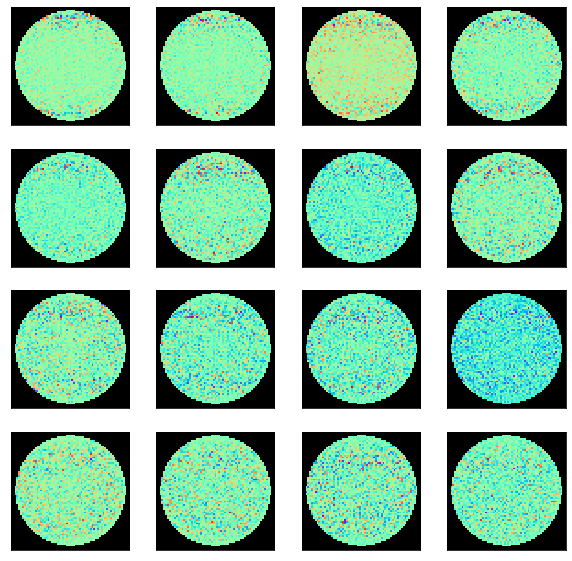

In [80]:
nsets = 4

fig, axes = plt.subplots(nsets,nsets,figsize=(10,10))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

for j, axis in enumerate(axes.ravel()):
    mode = 1.*onp.array(support)
    mode[support==1.] = v1[j*50+1000,:]
    mode[support<1.] = np.nan

    axis.imshow(mode,cmap=phasemap)  
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

plt.savefig('/Users/benjaminpope/code/anoroc/paper/kernel_modes_mono.pdf',bbox_inches='tight')